In [ ]:
import kagglehub
faizankhan20cab105_lung_c_path = kagglehub.dataset_download('faizankhan20cab105/lung-c')

print('Data source import complete.')

100%|██████████| 617M/617M [00:05<00:00, 119MB/s]

Extracting files...


Data source import complete.


In [ ]:
faizankhan20cab105_lung_c_path

'/root/.cache/kagglehub/datasets/faizankhan20cab105/lung-c/versions/1'

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_dir = "/root/.cache/kagglehub/datasets/faizankhan20cab105/lung-c/versions/1/lung cancer pictures/Train"
test_dir = "/root/.cache/kagglehub/datasets/faizankhan20cab105/lung-c/versions/1/lung cancer pictures/Test"

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((224, 224)),  # Resizing
    transforms.ToTensor(),  # Converting to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalizing pixel values
])

train_data = datasets.ImageFolder(root=train_dir, transform=transform)
test_data = datasets.ImageFolder(root=test_dir, transform=transform)

In [ ]:
from torch.utils.data import random_split

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size

train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

In [ ]:
print(len(train_dataset), len(val_dataset), len(test_data))

2793 699 1152


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

Counter({0: 2244, 1: 1248})


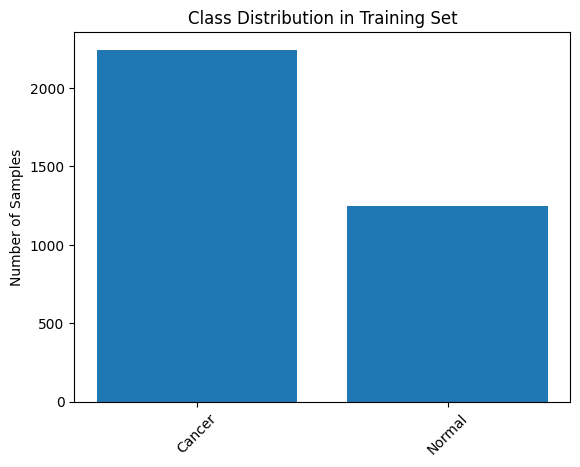

Counter({0: 624, 1: 528})


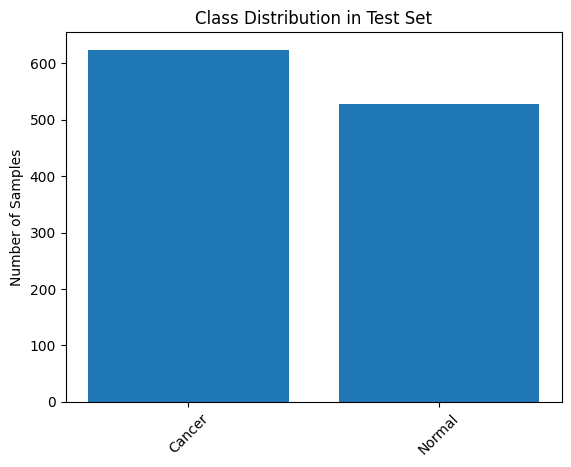

In [ ]:
#Count the number of samples in ea
from collections import Counter
import matplotlib.pyplot as plt

def visualize_class_distribution(data, title):
    counter = Counter(data.targets)
    print(counter)
    plt.bar(['Cancer', 'Normal'], counter.values())
    plt.title(title)
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.show()

visualize_class_distribution(train_data, "Class Distribution in Training Set")
visualize_class_distribution(test_data, "Class Distribution in Test Set")


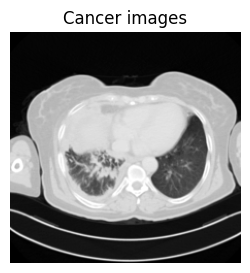

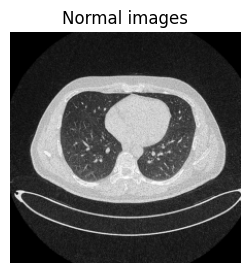

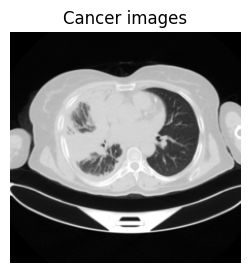

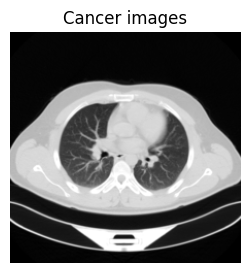

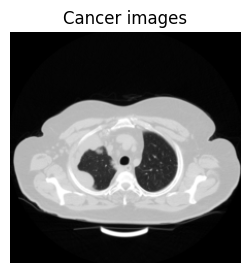

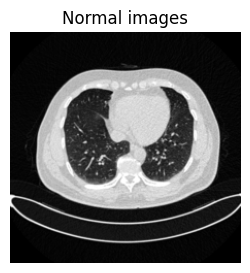

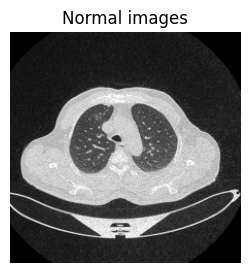

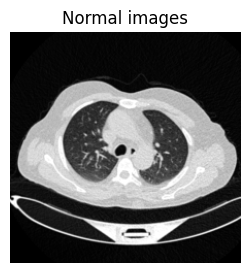

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.axis('off')

dataiter = iter(train_loader)
images, labels = next(dataiter)

# Plotting each image
for idx in range(8):
    plt.figure(figsize=(3, 3))
    imshow(images[idx])
    plt.title(train_data.classes[labels[idx]])
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 500)
        self.fc2 = nn.Linear(500, 2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)  # Flattening step
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
model = Net()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
model

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store losses
train_losses = []
valid_losses = []

# Training settings
early_stop_patience = 2
epochs_no_improve = 0
n_epochs = 20
valid_loss_min = np.Inf  # Track minimum validation loss

# Training and validation loop
for epoch in range(1, n_epochs + 1):
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # Train the model #
    ###################
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)  # Multiply by batch size

    ######################
    # Validate the model #
    ######################
    model.eval()
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)

    # Calculate average losses
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(val_loader.sampler)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Print statistics
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')

    # Save model if validation loss decreases
    if valid_loss <= valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve == early_stop_patience:
        print(f'Early stopping triggered.')
        break

Epoch: 1 	Training Loss: 0.754841 	Validation Loss: 0.424497
Validation loss decreased (inf --> 0.424497). Saving model ...
Epoch: 2 	Training Loss: 0.270657 	Validation Loss: 0.155922
Validation loss decreased (0.424497 --> 0.155922). Saving model ...
Epoch: 3 	Training Loss: 0.082780 	Validation Loss: 0.026551
Validation loss decreased (0.155922 --> 0.026551). Saving model ...
Epoch: 4 	Training Loss: 0.013604 	Validation Loss: 0.008670
Validation loss decreased (0.026551 --> 0.008670). Saving model ...
Epoch: 5 	Training Loss: 0.003946 	Validation Loss: 0.001976
Validation loss decreased (0.008670 --> 0.001976). Saving model ...
Epoch: 6 	Training Loss: 0.001664 	Validation Loss: 0.000988
Validation loss decreased (0.001976 --> 0.000988). Saving model ...
Epoch: 7 	Training Loss: 0.000921 	Validation Loss: 0.000570
Validation loss decreased (0.000988 --> 0.000570). Saving model ...
Epoch: 8 	Training Loss: 0.000687 	Validation Loss: 0.000403
Validation loss decreased (0.000570 --> 0

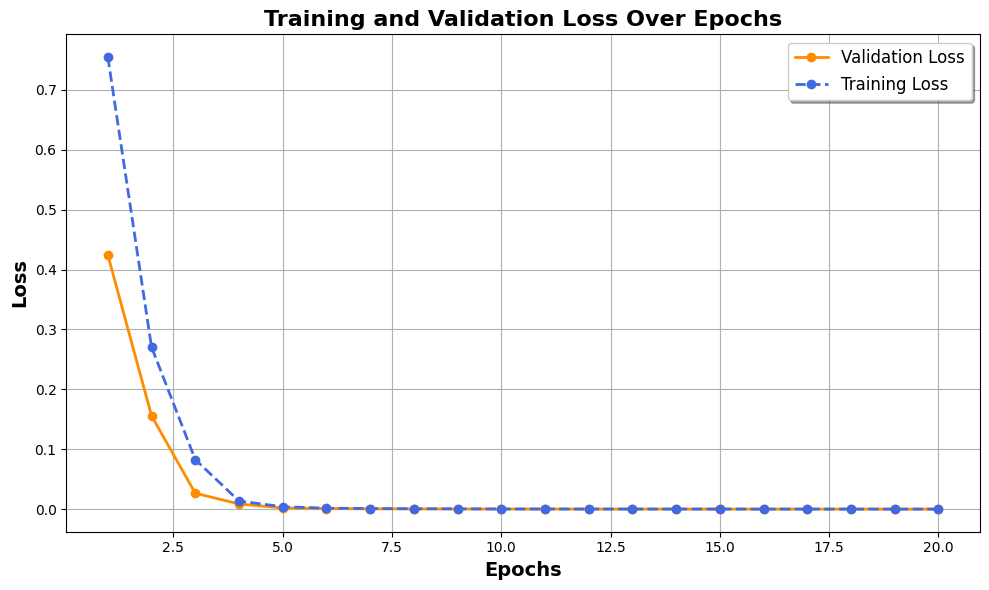

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses)+1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, valid_losses, label='Validation Loss', linestyle='-', marker='o', linewidth=2, color='darkorange')
plt.plot(epochs, train_losses, label='Training Loss', linestyle='--', marker='o', linewidth=2, color='royalblue')
plt.title('Training and Validation Loss Over Epochs', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.grid(visible=True)
plt.legend(fontsize=12, loc='upper right', shadow=True)
plt.tight_layout()

plt.show()

In [ ]:
# Track test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
size = len(test_data)

predictions = np.zeros(size)
all_classes = np.zeros(size)
all_proba = np.zeros((size, 2))
idx = 0

model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)
        _, pred = torch.max(output, 1)

        # Compare predictions to true labels
        correct_tensor = pred.eq(target.view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy())

        predictions[idx:idx+len(target)] = pred.cpu().numpy()
        all_classes[idx:idx+len(target)] = target.cpu().numpy()
        all_proba[idx:idx+len(target), :] = output.cpu().numpy()
        idx += len(target)

        # Calculating test accuracy for each class
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

# Average test loss
test_loss = test_loss / len(test_loader.dataset)

# Print results
print(f'Test Loss: {test_loss:.6f}\n')

# Per-class accuracy
for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            train_data.classes[i], 100 * class_correct[i] / class_total[i],
            int(class_correct[i]), int(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

# Overall accuracy
overall_accuracy = 100. * sum(class_correct) / sum(class_total)
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    overall_accuracy, int(sum(class_correct)), int(sum(class_total))))

Test Loss: 0.000026

Test Accuracy of Cancer images: 100% (624/624)
Test Accuracy of Normal images: 100% (528/528)

Test Accuracy (Overall): 100% (1152/1152)


In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def make_fig_cm(cm, classes):
    fig = plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=0)
    plt.tight_layout()
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        coeff = f'{cm[i, j]}'
        plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted', fontsize=12, fontweight='bold')

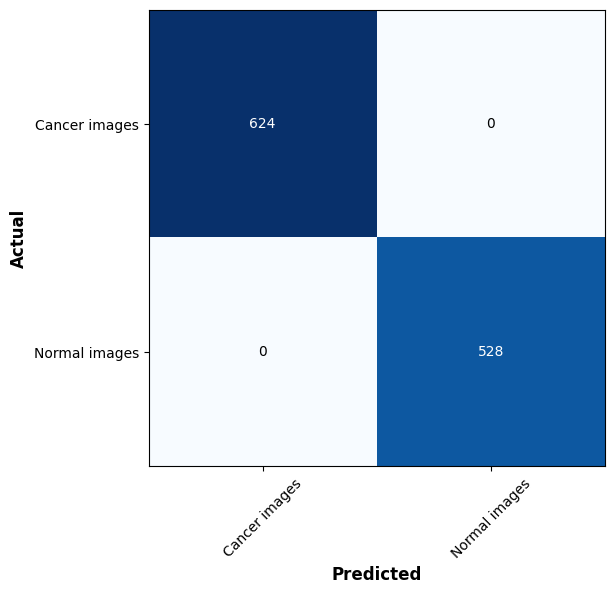

In [ ]:
classes = train_data.classes
cm = confusion_matrix(all_classes, predictions)
make_fig_cm(cm, classes)